In this notebook, I will be finding ways to predict home prices using primarily regression techniques.

First I import the necessary libraries below and read the train and test data. I will make a copy of both data in case I need to reference the original.

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
train_data = train.copy()
test_data = test.copy()

%matplotlib inline  

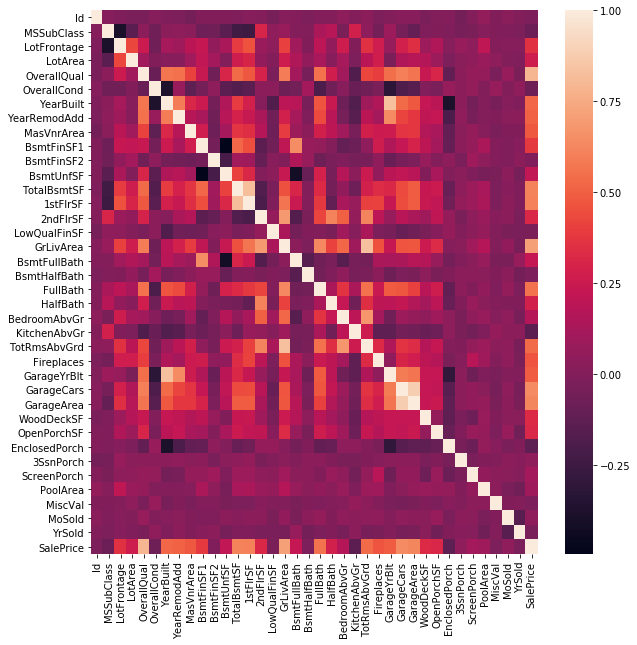

In [232]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(train.corr(), ax=ax)

Text(0.5, 1.0, 'Missing Data')

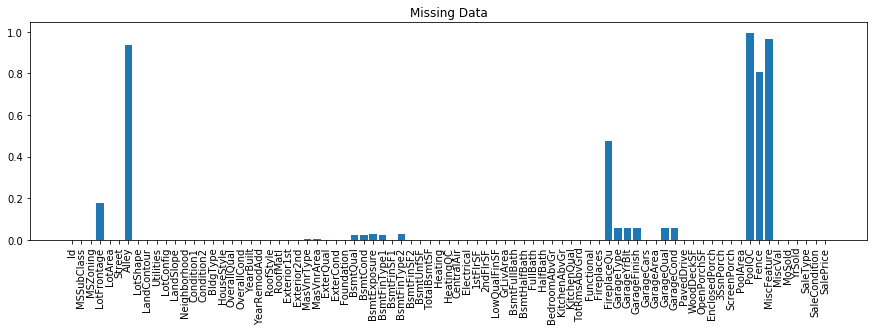

In [233]:
fig, ax = plt.subplots(figsize=(15,4)) 
plt.xticks(rotation="vertical")
plt.bar(train_data.columns,train_data.isnull().sum()/len(train_data))
plt.title("Missing Data")

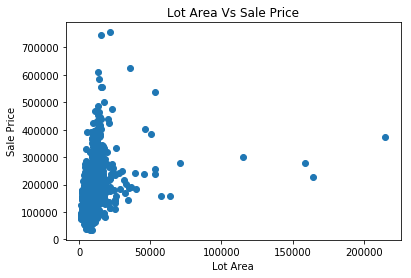

In [234]:
plt.xlabel("Lot Area")
plt.ylabel("Sale Price")
plt.title("Lot Area Vs Sale Price")
plt.scatter(train_data["LotArea"],train_data["SalePrice"])


In [235]:
train_data.sort_values(by="LotArea", ascending=False).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000


In [236]:
train_data = train_data.drop([313,335,249,706]).reset_index(drop=True)

In [237]:
train_data = train_data.drop(["PoolQC", "Id", "Alley","Fence", "MiscFeature", "FireplaceQu"], axis=1)
test_data = test_data.drop(["PoolQC", "Id","Alley","Fence", "MiscFeature", "FireplaceQu"], axis=1)

In [238]:
lr_train_cols_impute = train_data.loc[:,train_data.isnull().any()].select_dtypes("number")
lr_test_cols_impute = test_data.loc[:,test_data.isnull().any()].select_dtypes("number")

In [239]:
def imputeLR(column, data):
    needLRImpute = data.loc[:,data.isnull().any()].select_dtypes("number")
    LRImputeMissingRows = needLRImpute[needLRImpute.isnull().any(axis=1)]
    LRcompleteRows = needLRImpute[~needLRImpute.isnull().any(axis=1)]
    
    train = data.copy()
    target = data[column]
    train = data.select_dtypes("number").drop(needLRImpute.columns, axis=1)
    
    imputeLr = LinearRegression()
    imputeLr.fit(train.iloc[LRcompleteRows.index],target.iloc[LRcompleteRows.index])
    LRImputeMissingRow = LRImputeMissingRows[LRImputeMissingRows[column].isnull()]
    
    return pd.Series(imputeLr.predict(train.iloc[LRImputeMissingRows.index]), index=LRImputeMissingRows.index, dtype='float64')
    

In [240]:
for item in lr_train_cols_impute.columns:
    train_data[item] = train_data[item].fillna(imputeLR(item, train_data))
for item in lr_test_cols_impute.columns:
    test_data[item] = test_data[item].fillna(imputeLR(item, test_data))
    

In [241]:
train_labelKNNImpute = train_data.loc[:,train_data.isnull().any()]
test_labelKNNImpute = test_data.loc[:,test_data.isnull().any()]

In [242]:
def knnImpute(col, data):
    copyData = data.copy()
    labelKNNImpute = data.loc[:,data.isnull().any()]
    
    copyData = copyData.drop(labelKNNImpute.columns, axis=1)
    
    labelCols = copyData.select_dtypes("object")
    copyData = pd.concat([copyData, pd.get_dummies(labelCols)], axis=1)
    copyData = copyData.drop(labelCols, axis=1)
    KNN = KNeighborsClassifier(5, weights='distance')
    
    currentTarget = labelKNNImpute[col]
    currentMissing = labelKNNImpute[labelKNNImpute[col].isnull()]
    
    indexOfComplete = labelKNNImpute[labelKNNImpute[col].notnull()].index
    
    currentTrain = copyData.iloc[indexOfComplete]
    currentTarget = currentTarget.iloc[indexOfComplete]
    fit = KNN.fit(currentTrain, currentTarget)
    
    return pd.Series(fit.predict(copyData.iloc[currentMissing.index]), index=currentMissing.index)

In [243]:
for item in train_labelKNNImpute.columns:
    train_data[item] = train_data[item].fillna(knnImpute(item, train_data))
    
for item in test_labelKNNImpute.columns:
    test_data[item] = test_data[item].fillna(knnImpute(item, test_data))

In [244]:
lr_data = train_data.copy()
drop_non_numeric = lr_data.select_dtypes("object")
lr_data = pd.concat([lr_data, pd.get_dummies(drop_non_numeric)], axis=1)
lr_data = lr_data.drop(drop_non_numeric, axis=1)

In [190]:
x_train, x_test, y_train, y_test = train_test_split(lr_data[lr_data.columns.difference(["SalePrice"])], lr_data["SalePrice"], test_size=0.2)

In [259]:
full_train = train_data.copy()
full_train[drop_non_numeric.columns] = full_train[drop_non_numeric.columns].astype("category")
full_train[drop_non_numeric.columns] = full_train[drop_non_numeric.columns].apply(lambda x: x.cat.codes)

In [260]:
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(full_train[full_train.columns.difference(["SalePrice"])], full_train["SalePrice"], test_size=0.2)

### Linear Regression with Lasso

In [261]:
from sklearn.model_selection import KFold

In [262]:
KF = KFold(n_splits=5, shuffle=True)

In [263]:
lasso = LassoCV()

In [264]:
lasso.fit(x_train,y_train)
chosenVar = pd.Series(lasso.coef_, index=x_train.columns)
chosenLR = lr_data[chosenVar[chosenVar > 0].index]

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [265]:
lr = LinearRegression()

In [266]:
lr_model = lr.fit(x_train[chosenLR.columns], y_train)

In [272]:
lr_with_lasso_scores = cross_val_score(lr, x_train[chosenLR.columns], y_train, cv=KF)

### Random Forest with Lasso

In [291]:
from sklearn.ensemble import RandomForestRegressor

In [293]:
tr = RandomForestRegressor(n_estimators=100)

In [294]:
tr_scores = cross_val_score(tr, x_train_full, y_train_full, cv=KF)

In [277]:
lasso_full = LassoCV()

In [278]:
lasso_full.fit(x_train_full, y_train_full)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [279]:
chosenVarFull = pd.Series(lasso_full.coef_, index=x_train_full.columns)
chosenLRFull = full_train[chosenVarFull[chosenVarFull > 0].index]

In [295]:
cross_val_score(tr, x_train_full[chosenLRFull.columns], y_train_full, cv=KF).mean()

0.8220478056135981

In [288]:
lr_with_lasso_scores.mean()

0.7066486256622682

In [297]:
tr_testing = RandomForestRegressor(n_estimators=100)

In [306]:
current_x = full_train.copy()

In [307]:
current_y = current_x["SalePrice"]
current_x = current_x.drop("SalePrice", axis=1)

In [328]:
tr_testing.fit(current_x[chosenLRFull.columns], current_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [312]:
full_test = test_data.copy()
full_test[drop_non_numeric.columns] = full_test[drop_non_numeric.columns].astype("category")
full_test[drop_non_numeric.columns] = full_test[drop_non_numeric.columns].apply(lambda x: x.cat.codes)

In [340]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(current_x, current_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

### Submission Codes

In [341]:
predictions = ada.predict(full_test)

In [342]:
currentSubmit = test_data.copy()
currentSubmit["SalePrice"] = predictions
currentSubmit["Id"] = test["Id"]

In [343]:
currentSubmit[["Id","SalePrice"]].to_csv("submission.csv", index=False)